***

# E-mail Spam Classification using LSTM

*Posted on October 2022*

***

In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

This notebook is meant to be an attempt to analyze email data. The data consist of emails with a label that inform whether the corresponding email is a spam or not spam. In this notebook I use wordcount to analyze whether the spam email is good enough for further approach such as creating email classifier. Lastly I use LSTM to create a machine learning model that classify whether an email is considered a spam or not spam.

First lets load the data.

In [2]:
df_train = pd.read_csv('../input/email-classification-nlp/SMS_train.csv', encoding='latin_1')

df_test = pd.read_csv('../input/email-classification-nlp/SMS_test.csv', encoding='latin_1')

In [3]:
df_train.describe()

,S. No.
count,957.000000
mean,479.000000
std,276.406404
min,1.000000
25%,240.000000
50%,479.000000
75%,718.000000
max,957.000000


In [4]:
df_test.describe()

,S. No.
count,125.000000
mean,63.000000
std,36.228442
min,1.000000
25%,32.000000
50%,63.000000
75%,94.000000
max,125.000000


The data divided into two parts, a train data and a test data. We will use the train data to both train and validate the model. The test data will be used as an unseen data to determine the performance of the model.

In [5]:
df_train

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam
...,...,...,...
952,953,hows my favourite person today? r u workin har...,Non-Spam
953,954,How much you got for cleaning,Non-Spam
954,955,Sorry da. I gone mad so many pending works wha...,Non-Spam
955,956,Wat time ü finish?,Non-Spam


First, lets take a look at wordcloud on emails that classifed as a spam.

## Wordcloud for spam messages

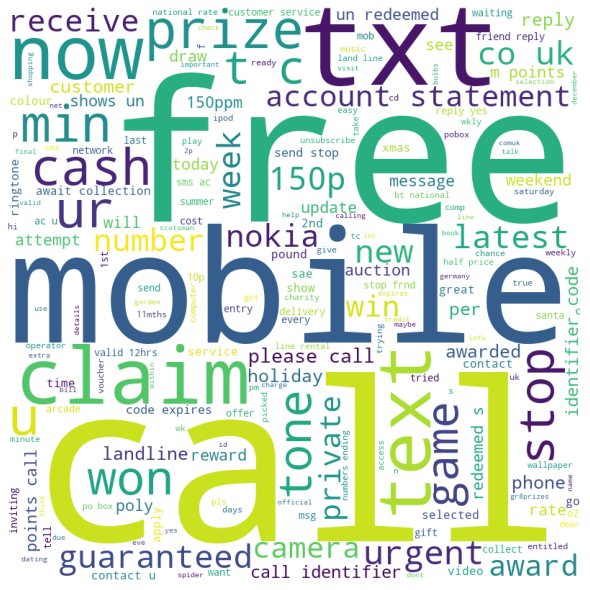

In [6]:
df_visualize = df_train[df_train['Label'] == 'Spam']


comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df_visualize['Message_body']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Based on this wordcloud we know that words like "call", "free", and "mobile" is being used a lot in spam emails. By my experience, a lot of ads use these kind of words to advertise their products. Thus the data is good enough for us to build a machine learning classifier.

## Neural Network spam detection

Lets count how many unique words we have to create the tokenizer

In [7]:
# count unique word
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

text_values = df_train['Message_body']

counter = counter_word(text_values)

Define a few model parameters. We will use 80% of the training data as the true training dataset which is about 765 and the rest of the training data will be used as validaton dataset.

In [8]:
# Model parameter

vocab_size = len(counter)
embedding_dim = df_train['Message_body'].str.len().max()

max_length = 20

training_size = 765

In [9]:
training_sentences = df_train['Message_body'][0:training_size]
training_labels = df_train['Label'][0:training_size]

val_sentences = df_train['Message_body'][training_size:]
val_labels = df_train['Label'][training_size:]

In [10]:
training_labels = training_labels.replace(['Spam'], 1)
training_labels = training_labels.replace(['Non-Spam'], 0)

val_labels = val_labels.replace(['Spam'], 1)
val_labels = val_labels.replace(['Non-Spam'], 0)

Lets tokenize and pad the data

In [11]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(training_sentences)

In [12]:
word_index = tokenizer.word_index

In [13]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length)

In [14]:
print(df_train['Message_body'][1])
print(training_sequences[1])

The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free
[6, 354, 130, 120, 1143, 38, 2, 1144, 57, 536, 40, 713, 8, 420, 229, 311, 164, 78, 10, 70, 537, 13, 3, 140, 12, 45]


Tokenize and pad the validation dataset aswell

In [15]:
val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=max_length)

# Model definition

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

2022-10-25 03:20:42.969154: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 446)           2167560   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               261632    
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 2,431,273
Trainable params: 2,431,273
Non-trainable params: 0
_________________________________________________________________


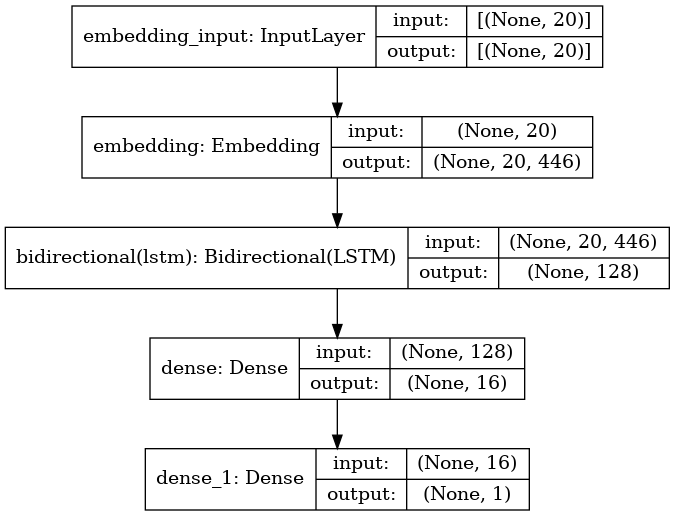

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Training the model

In [20]:
# start training
epochs = 10
history = model.fit(training_padded, training_labels, epochs=epochs, validation_data=(val_padded, val_labels))

2022-10-25 03:20:45.354437: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
24/24 [==============================] - 7s 95ms/step - loss: 0.3344 - accuracy: 0.8784 - val_loss: 0.1613 - val_accuracy: 0.9427
Epoch 2/10
24/24 [==============================] - 1s 55ms/step - loss: 0.1055 - accuracy: 0.9843 - val_loss: 0.0853 - val_accuracy: 0.9635
Epoch 3/10
24/24 [==============================] - 1s 58ms/step - loss: 0.0280 - accuracy: 0.9961 - val_loss: 0.1016 - val_accuracy: 0.9688
Epoch 4/10
24/24 [==============================] - 1s 58ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.1515 - val_accuracy: 0.9583
Epoch 5/10
24/24 [==============================] - 1s 56ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.1156 - val_accuracy: 0.9635
Epoch 6/10
24/24 [==============================] - 1s 57ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1277 - val_accuracy: 0.9635
Epoch 7/10
24/24 [==============================] - 1s 55ms/step - loss: 6.2759e-04 - accuracy: 1.0000 - val_loss: 0.1338 - val_accuracy: 0.9635
Epoch 8/1

In [21]:
model_loss = pd.DataFrame(model.history.history)
model_loss

,loss,accuracy,val_loss,val_accuracy
0,0.334381,0.878431,0.161303,0.942708
1,0.105477,0.984314,0.085291,0.963542
2,0.027962,0.996078,0.101602,0.968750
3,0.012480,0.996078,0.151530,0.958333
4,0.004808,0.998693,0.115609,0.963542
5,0.001038,1.000000,0.127676,0.963542
6,0.000628,1.000000,0.133848,0.963542
7,0.000457,1.000000,0.136957,0.963542
8,0.000352,1.000000,0.139128,0.963542
9,0.000281,1.000000,0.144294,0.958333


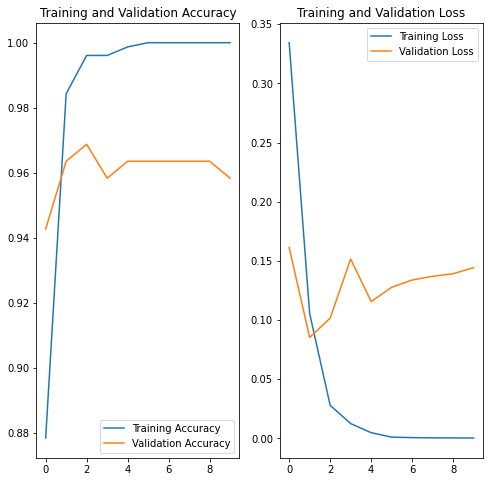

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The final performance of the data is 100% accuracy on the training data and about 96% accuracy on the validation data.

# Prediction on Unseen data

Lets use the unseen test data to see the real performance of the model

Lets tokenize and pad the test data

In [23]:
testing_sentences = df_test['Message_body']
testing_labels = df_test['Label']

testing_labels = testing_labels.replace(['Spam'], 1)
testing_labels = testing_labels.replace(['Non-Spam'], 0)

In [24]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

Predict the test data

In [25]:
predictions = model.predict(testing_padded)

In [26]:
testing_labels = pd.DataFrame(testing_labels)
testing_labels['Prediction'] = predictions

<AxesSubplot:xlabel='Prediction', ylabel='Count'>

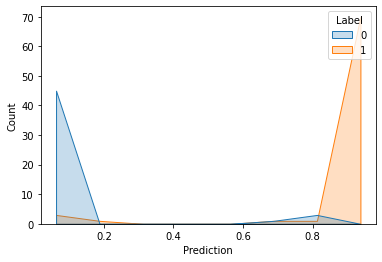

In [27]:
sns.histplot(testing_labels, x='Prediction', hue='Label', element='poly')

As you can see by the plot above, the model seems did a good job on classifying the email. But lets see how the performance with metric

In [28]:
# Scoring metric for prediction

testing_labels['Prediction_labels'] = (testing_labels['Prediction'] > 0.5).astype(int)

In [29]:
accuracy = accuracy_score(testing_labels['Label'], testing_labels['Prediction_labels'])

print('Accuracy: {}'.format(accuracy))
print(classification_report(testing_labels['Label'], testing_labels['Prediction_labels']))

Accuracy: 0.936
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        49
           1       0.95      0.95      0.95        76

    accuracy                           0.94       125
   macro avg       0.93      0.93      0.93       125
weighted avg       0.94      0.94      0.94       125



<AxesSubplot:>

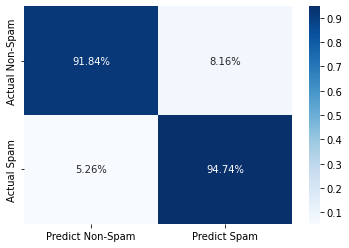

In [30]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(testing_labels['Label'], testing_labels['Prediction_labels']))
cm.columns = ['Predict Non-Spam', 'Predict Spam']
cm.index = ['Actual Non-Spam', 'Actual Spam']
cm.iloc[0] = cm.iloc[0]/cm.sum(axis=1)[0]
cm.iloc[1] = cm.iloc[1]/cm.sum(axis=1)[1]

sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2%')

The F1 score of the model on the unseen data is about 94% which is good. Also, the model is able to predict 100% accuracy on the non-spam email while the model predict 89.47% accuracy on the spam email. Which is in my opinion is good considering we dont want our model to falsely predict a non-spam email as a spam email while the vice versa is allowed to a certain degree.

Thankyou for reading this!